In [ ]:
ch5_model_free_RL时序差分算法

In [ ]:
第 4 章介绍的动态规划算法要求马尔可夫决策过程是已知的，即要求与智能体交互的环境是完全已知的
（例如迷宫或者给定规则的网格世界）。
在此条件下，智能体其实并不需要和环境真正交互来采样数据，直接用动态规划算法就可以解出最优价值或策略。
这就好比对于有监督学习任务，如果直接显式给出了数据的分布公式，
那么也可以通过在期望层面上直接最小化模型的泛化误差来更新模型参数，并不需要采样任何数据点。

In [ ]:
5.2 时序差分方法

In [ ]:
时序差分是一种用来估计一个策略的价值函数的方法，它结合了蒙特卡洛和动态规划算法的思想。
时序差分方法和蒙特卡洛的相似之处在于可以从样本数据中学习，不需要事先知道环境；
和动态规划的相似之处在于根据贝尔曼方程的思想，利用后续状态的价值估计来更新当前状态的价值估计。

In [ ]:
5.3 Sarsa 算法

In [ ]:
可以得到一个实际的基于时序差分方法的强化学习算法。
这个算法被称为 Sarsa，因为它的动作价值更新用到了当前状态、当前动作、获得的奖励、
下一个状态和下一个动作，将这些符号拼接后就得到了算法名称

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [2]:
class Sarsa:
    """ Sarsa算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state):  # 选取下一步的操作,具体实现为epsilon-贪婪
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Iteration 0: 100%|█| 50/50 [00:00<00:00, 1387.00it/s, episode=50, return=-119.40
Iteration 1: 100%|█| 50/50 [00:00<00:00, 1872.76it/s, episode=100, return=-63.00
Iteration 2: 100%|█| 50/50 [00:00<00:00, 2270.26it/s, episode=150, return=-51.20
Iteration 3: 100%|█| 50/50 [00:00<00:00, 2730.13it/s, episode=200, return=-48.10
Iteration 4: 100%|█| 50/50 [00:00<00:00, 3037.94it/s, episode=250, return=-35.70
Iteration 5: 100%|█| 50/50 [00:00<00:00, 3379.23it/s, episode=300, return=-29.90
Iteration 6: 100%|█| 50/50 [00:00<00:00, 4185.60it/s, episode=350, return=-28.30
Iteration 7: 100%|█| 50/50 [00:00<00:00, 4376.18it/s, episode=400, return=-27.70
Iteration 8: 100%|█| 50/50 [00:00<00:00, 3904.66it/s, episode=450, return=-28.50
Iteration 9: 100%|█| 50/50 [00:00<00:00, 3809.13it/s, episode=500, return=-18.90


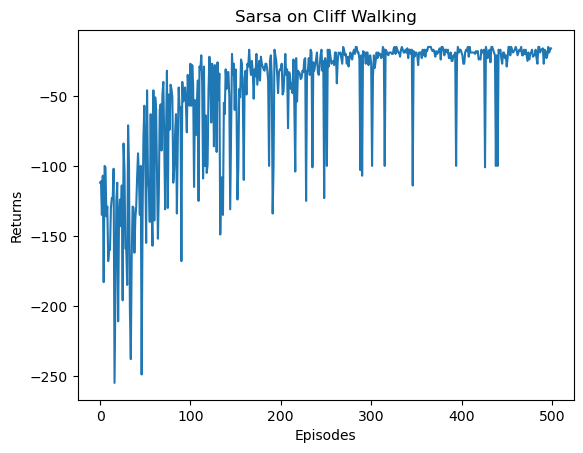

In [3]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()